# Redes Neurais Recorrentes

### Descriçao

---
1. O objetivo deste notebook é construir uma Rede Neural Recorrente.
2. Utilizaremos o conjunto de dados proposto no [gist treino](https://gist.githubusercontent.com/batestin1/b8f7c0a26c9669013ba451c18e381d75/raw/e355693a14880cd8dbe2bee26a52dafdc9aaabec/gistfile1.txt) e [gist test](https://gist.githubusercontent.com/batestin1/f94107b82cc271c203c1d5843b8dded3/raw/f5e653d96b45bb19773230b5090c78f0695f8919/gistfile1.txt)

3. O problema consiste em prever as ações temporais do preço da Google na bolsa de valores
---

# Instalação dos pacotes

In [1]:
!pip install pandas numpy scikit-learn keras matplotlib

# Instalando as bibliotecas




In [2]:
# Bibliotecas essenciais

import numpy as np  # NumPy: usado para manipular matrizes e fazer cálculos matemáticos rápidos
import matplotlib.pyplot as plt  # Matplotlib: para criar gráficos e visualizar dados
import pandas as pd  # Pandas: facilita a manipulação de tabelas e séries de dados

# Pré-processamento para Machine Learning

from sklearn.preprocessing import MinMaxScaler  # Normaliza os dados para deixá-los no mesmo intervalo (0 a 1)

# Construção de redes neurais com Keras

from keras.models import Sequential  # Define a rede neural como uma sequência linear de camadas
from keras.layers import Dense  # Cria camadas totalmente conectadas (camadas densas)
from keras.layers import LSTM  # Adiciona uma camada LSTM (ótima para dados sequenciais e séries temporais)
from keras.layers import Dropout  # Aplica "dropout" para evitar overfitting (zerando conexões aleatórias durante treino)

# Trabalhando com arquivos e modelos

import os  # Permite criar, listar e gerenciar pastas e arquivos no sistema
from keras.models import load_model  # Carrega modelos já treinados do Keras

# Redes neurais com PyTorch

import torch  # Biblioteca principal do PyTorch para tensores e computação acelerada
import torch.nn as nn  # Criação de redes neurais (define as camadas e funções de perda)
import torch.nn.parallel  # Facilita treinar modelos em múltiplas GPUs (quando disponível)
import torch.optim as optim  # Algoritmos para otimização dos pesos da rede (ex: Adam, SGD)
import torch.utils.data  # Ferramentas para trabalhar com datasets no PyTorch
from torch.autograd import Variable  # Permite que os tensores calculem gradientes automaticamente (autograd)

# Obtendo o dataset

In [3]:
# Lendo o conjunto de dados

df = pd.read_csv(
  'https://gist.githubusercontent.com/batestin1/b8f7c0a26c9669013ba451c18e381d75/raw/e355693a14880cd8dbe2bee26a52dafdc9aaabec/gistfile1.txt'
)

# Lê o arquivo CSV diretamente da URL e armazena em um DataFrame chamado 'df'
# O Pandas facilita essa leitura direto da web, sem precisar baixar manualmente o arquivo

#### Conhecendo o dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [5]:
# Analisando o período coberto pelos dados

ano_inicial = df['Date'].min()  # Pega a primeira data (mais antiga) da coluna 'Date'
ano_final = df['Date'].max()  # Pega a última data (mais recente) da coluna 'Date'

# Imprime o intervalo de tempo
print(ano_inicial[5:], ano_final[4:])

# Nota:
# ano_inicial[5:] pega do 6º caractere em diante da data (talvez para remover o ano ou o formato completo)
# ano_final[4:] pega do 5º caractere em diante — o corte pode ser para ajeitar o formato da impressão

2012 2016


# Pré Processamento

In [6]:
# Separando os dados de treino

training_set = df.iloc[:, 1:2].values
# Seleciona apenas a segunda coluna do DataFrame (índice 1), que é a coluna 'Open' (preço de abertura)
# .iloc[:, 1:2] -> ':' pega todas as linhas, '1:2' pega da coluna 1 até ANTES da coluna 2 (por isso só a coluna 1)
# .values -> transforma o resultado em um array NumPy, que é o formato esperado pelas redes neurais

In [7]:
# Conferindo se a separação dos dados está correta

num = 115  # Define o índice da linha que vamos comparar

print(f"comparando o training_set: {training_set[num][0]} X coluna open: {df['Open'][num]}")

# Compara o valor da linha 115 no array 'training_set' com o valor correspondente na coluna 'Open' do DataFrame
# Esse teste é importante para garantir que a extração dos dados foi feita corretamente

comparando o training_set: 280.26 X coluna open: 280.26


In [8]:
# Normalizando os dados de treino

sc = MinMaxScaler(feature_range=(0, 1))
# Cria um objeto MinMaxScaler para escalar os dados entre 0 e 1
# A normalização é importante para melhorar o desempenho do treinamento da rede neural

training_set_scaled = sc.fit_transform(training_set)
# Aplica a transformação nos dados de treino
# O fit_transform calcula os parâmetros (mínimo e máximo) e já aplica a escala

training_set_scaled
# Exibe o resultado (valores agora estarão entre 0 e 1)

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [9]:
training_set_scaled.shape

(1258, 1)

In [10]:
# Criando as estruturas de dados com 60 intervalos de tempo

X_train = []  # Lista para armazenar os 60 dias anteriores (features)
y_train = []  # Lista para armazenar o valor do próximo dia (label)

for i in range(60, len(training_set_scaled)):
  # Começa do índice 60 até o final do conjunto de treino
  # O modelo sempre vai olhar 60 dias para trás para prever o próximo dia

  X_train.append(training_set_scaled[i-60:i, 0])
  # Pega os 60 valores anteriores ao dia i e adiciona na lista X_train

  y_train.append(training_set_scaled[i, 0])
  # Pega o valor do dia atual (i) como valor esperado e adiciona na lista y_train

X_train, y_train = np.array(X_train), np.array(y_train)
# Converte as listas para arrays NumPy, que é o formato aceito pelos modelos

In [11]:
X_train.shape

(1198, 60)

In [12]:
# Ajustando o formato dos dados para a LSTM
# A LSTM do Keras espera a entrada no formato 3D: (amostras, passos de tempo, características)

parametros = (
  X_train.shape[0],  # Número de amostras (linhas) — quantos exemplos temos
  X_train.shape[1],  # Número de passos de tempo — quantos dias (60 dias)
  1  # Número de características por passo de tempo — aqui só temos 1 (o preço de abertura "Open")
)

X_train = np.reshape(X_train, (parametros))
# Redimensiona o X_train para o formato esperado (samples, time_steps, features)

X_train.shape
# Exibe o novo formato da matriz (deve ser algo como (n_amostras, 60, 1))

(1198, 60, 1)

In [13]:
X_train

array([[[0.08581368],
        [0.09701243],
        [0.09433366],
        ...,
        [0.07846566],
        [0.08034452],
        [0.08497656]],

       [[0.09701243],
        [0.09433366],
        [0.09156187],
        ...,
        [0.08034452],
        [0.08497656],
        [0.08627874]],

       [[0.09433366],
        [0.09156187],
        [0.07984225],
        ...,
        [0.08497656],
        [0.08627874],
        [0.08471612]],

       ...,

       [[0.92106928],
        [0.92438053],
        [0.93048218],
        ...,
        [0.95475854],
        [0.95204256],
        [0.95163331]],

       [[0.92438053],
        [0.93048218],
        [0.9299055 ],
        ...,
        [0.95204256],
        [0.95163331],
        [0.95725128]],

       [[0.93048218],
        [0.9299055 ],
        [0.93113327],
        ...,
        [0.95163331],
        [0.95725128],
        [0.93796041]]])

# Construindo nossa RNR

In [14]:
# Inicializando a Rede Neural Recorrente (RNR)

rnr = Sequential()
# Cria um modelo sequencial do Keras
# O modelo 'Sequential' permite adicionar camadas uma após a outra, de forma linear

In [15]:
# Criando as camadas da Rede Neural Recorrente (RNR)

rnr.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# Adiciona a primeira camada LSTM com 50 unidades (neurônios)
# return_sequences=True permite que a saída seja uma sequência, necessária para empilhar outras camadas LSTM
# input_shape define o formato da entrada (número de passos de tempo, número de features)

rnr.add(Dropout(0.2))
# Adiciona um Dropout de 20% — desativa aleatoriamente 20% dos neurônios para evitar overfitting

rnr.add(LSTM(units=50, return_sequences=True))
# Segunda camada LSTM, também retorna sequências para empilhar outra LSTM

rnr.add(Dropout(0.2))
# Novo Dropout para regularização

rnr.add(LSTM(units=50, return_sequences=True))
# Terceira camada LSTM, continuando a estrutura empilhada

rnr.add(Dropout(0.2))
# Dropout para regularizar mais uma vez

rnr.add(LSTM(units=50))
# Quarta camada LSTM, agora sem return_sequences (última camada LSTM)

rnr.add(Dropout(0.2))
# Dropout novamente

rnr.add(Dense(units=1))
# Camada densa de saída com 1 unidade
# Ela gera a previsão final (um único valor contínuo, o próximo preço)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Compilando a Rede Neural Recorrente (RNR)

rnr.compile(optimizer='adam', loss='mean_squared_error')
# Compila o modelo definindo:
# - optimizer='adam': algoritmo de otimização que ajusta os pesos de forma eficiente
# - loss='mean_squared_error': função de perda usada para problemas de regressão
#   (mede a média dos quadrados dos erros entre o valor real e o valor previsto)

In [17]:
# Treinando o modelo

rnr.fit(X_train, y_train, epochs=50, batch_size=32)
# Treina o modelo com:
# - epochs=50: número de vezes que o modelo irá passar por todo o conjunto de treino
# - batch_size=32: número de amostras que serão propagadas na rede antes de atualizar os pesos
# O treinamento ajusta os pesos para minimizar a função de perda (mean_squared_error)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - loss: 0.0927
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0072
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0060
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0061
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0055
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.0049
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.0045
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.0048
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0054
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.0047
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0041
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0033
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - loss: 0.0041
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0039
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - 

# Testando

In [18]:
# Importando os dados de teste

dados_de_teste = pd.read_csv('https://gist.githubusercontent.com/batestin1/f94107b82cc271c203c1d5843b8dded3/raw/f5e653d96b45bb19773230b5090c78f0695f8919/gistfile1.txt')
# Lendo o arquivo CSV contendo os dados que serão usados para testar o modelo treinado

dados_de_teste
# Exibindo o dataframe de teste para verificar o conteúdo carregado

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"
5,1/10/2017,807.86,809.13,803.51,804.79,"1,176,800"
6,1/11/2017,805.00,808.15,801.37,807.91,"1,065,900"
7,1/12/2017,807.14,807.39,799.17,806.36,"1,353,100"
8,1/13/2017,807.48,811.22,806.69,807.88,"1,099,200"
9,1/17/2017,807.08,807.14,800.37,804.61,"1,362,100"


In [19]:
# Separando a coluna 'Open' dos dados de teste

abertura_real = dados_de_teste.iloc[:, 1:2].values
# Selecionando apenas a coluna 'Open' (valores de abertura) dos dados de teste
# Usando [:, 1:2] para manter a estrutura como matriz (não transformar em vetor)

abertura_real
# Exibindo os valores reais de abertura do mercado para o conjunto de teste

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

In [20]:
# Concatenando dados de treino e teste

dataset_total = pd.concat((df['Open'], dados_de_teste['Open']), axis=0)
# Concatenando as colunas 'Open' dos dados de treino (df) e dos dados de teste (dados_de_teste)
# axis=0 indica que a concatenação é feita verticalmente (um abaixo do outro)

dataset_total
# Exibindo o conjunto total de dados concatenado

,Open
0,325.25
1,331.27
2,329.83
3,328.34
4,322.04
...,...
15,829.62
16,837.81
17,834.71
18,814.66


In [21]:
# Preparando os inputs para o modelo

inputs = dataset_total[len(dataset_total) - len(dados_de_teste) - 60:].values
# Selecionando os dados a partir de 60 dias antes do início do conjunto de teste
# Isso garante que o modelo tenha informações históricas suficientes para fazer as primeiras previsões
# .values transforma o resultado em um array numpy

inputs
# Exibindo os valores dos inputs preparados


array([779.  , 779.66, 777.71, 786.66, 783.76, 781.22, 781.65, 779.8 ,
       787.85, 798.24, 803.3 , 795.  , 804.9 , 816.68, 806.34, 801.  ,
       808.35, 795.47, 782.89, 778.2 , 767.25, 750.66, 774.5 , 783.4 ,
       779.94, 791.17, 756.54, 755.6 , 746.97, 755.2 , 766.92, 771.37,
       762.61, 772.63, 767.73, 764.26, 760.  , 771.53, 770.07, 757.44,
       744.59, 757.71, 764.73, 761.  , 772.48, 780.  , 785.04, 793.9 ,
       797.4 , 797.34, 800.4 , 790.22, 796.76, 795.84, 792.36, 790.9 ,
       790.68, 793.7 , 783.33, 782.75, 778.81, 788.36, 786.08, 795.26,
       806.4 , 807.86, 805.  , 807.14, 807.48, 807.08, 805.81, 805.12,
       806.91, 807.25, 822.3 , 829.62, 837.81, 834.71, 814.66, 796.86])

In [22]:
# Organizando os inputs para o formato de matriz necessário para o modelo

inputs = inputs.reshape(-1, 1)
# Ajustando o array para ter uma dimensão (linhas) automática e 1 coluna
# Isso é necessário porque o modelo espera os dados nesse formato (matriz 2D)

inputs.shape
# Mostrando o formato final dos inputs

(80, 1)

In [23]:
# Padronizando os inputs

inputs = sc.transform(inputs)
# Aplicando a mesma transformação usada nos dados de treino
# Isso mantém os dados na mesma escala (entre 0 e 1), essencial para a rede neural funcionar corretamente

inputs
# Exibindo os inputs já padronizados

array([[0.9299055 ],
       [0.93113327],
       [0.92750577],
       [0.94415507],
       [0.93876032],
       [0.93403527],
       [0.93483518],
       [0.9313937 ],
       [0.94636878],
       [0.96569685],
       [0.97510976],
       [0.95966962],
       [0.97808617],
       [1.        ],
       [0.98076494],
       [0.97083116],
       [0.98450406],
       [0.96054394],
       [0.9371419 ],
       [0.92841729],
       [0.90804747],
       [0.8771858 ],
       [0.92153434],
       [0.93809063],
       [0.93165414],
       [0.95254483],
       [0.88812412],
       [0.88637547],
       [0.87032145],
       [0.88563137],
       [0.90743359],
       [0.91571173],
       [0.89941588],
       [0.91805566],
       [0.9089404 ],
       [0.9024853 ],
       [0.89456061],
       [0.91600938],
       [0.9132934 ],
       [0.88979835],
       [0.86589404],
       [0.89030062],
       [0.90335962],
       [0.89642086],
       [0.91777662],
       [0.93176576],
       [0.94114145],
       [0.957

In [24]:
# Preparando os dados de teste no mesmo formato que os dados de treino

X_test = []
for i in range(60, inputs.shape[0]):
  X_test.append(inputs[i-60:i, 0])
  # Para cada ponto de teste, pegamos os 60 dias anteriores como entrada

X_test = np.array(X_test)
# Convertendo a lista para um array NumPy

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Remodelando o array para 3 dimensões (número de exemplos, passos de tempo, 1 indicador)
# Formato necessário para entrada no modelo LSTM

In [25]:
# Obtendo as previsões do modelo treinado

print(f"previsao oficial: {rnr.predict(X_test)}")
# Previsão no formato padronizado (valores entre 0 e 1)

print(f"previsao revertida: {sc.inverse_transform(rnr.predict(X_test))}")
# Previsão revertida para os valores originais usando o inverso da transformação do MinMaxScaler

variavel_final = sc.inverse_transform(rnr.predict(X_test))
# Salvando a previsão revertida em uma variável final para análises posteriores

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
previsao oficial: [[0.9326032 ]
 [0.9294402 ]
 [0.92623526]
 [0.9234357 ]
 [0.92171156]
 [0.9218593 ]
 [0.924132  ]
 [0.9280812 ]
 [0.93307424]
 [0.9384303 ]
 [0.9435378 ]
 [0.9479054 ]
 [0.9512421 ]
 [0.9535622 ]
 [0.95502424]
 [0.95651144]
 [0.95889086]
 [0.9628187 ]
 [0.9681178 ]
 [0.97327423]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
previsao revertida: [[780.4502 ]
 [778.7499 ]
 [777.02704]
 [775.52203]
 [774.5952 ]
 [774.6747 ]
 [775.89636]
 [778.01935]
 [780.70337]
 [783.5826 ]
 [786.3282 ]
 [788.676  ]
 [790.46967]
 [791.7169 ]
 [792.5028 ]
 [793.3023 ]
 [794.58136]
 [796.6928 ]
 [799.5414 ]
 [802.3133 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [26]:
abertura_real[9][0]

np.float64(807.08)

In [27]:
# Comparando a abertura real com a previsão do modelo para um ponto específico (índice 7)

print(f"abertura oficial: {abertura_real[7][0]}")
# Imprime o valor real da abertura no índice 7

print(f"previsao obtida {round(sc.inverse_transform(rnr.predict(X_test))[7][0])}")
# Imprime o valor previsto (já revertido para a escala original) para o índice 7, arredondado

abertura oficial: 807.14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
previsao obtida 778


In [28]:
# Filtrando o DataFrame 'dados_de_teste' para encontrar todas as linhas onde a coluna 'Open' é exatamente igual a 807.14

dados_de_teste[dados_de_teste['Open'] == 807.14]

,Date,Open,High,Low,Close,Volume
7,1/12/2017,807.14,807.39,799.17,806.36,"1,353,100"


In [29]:
# Calculando a previsão do modelo

# Obtendo o valor previsto para o índice 7, revertendo a escala (desnormalizando) e arredondando para duas casas decimais
valor_final = round(sc.inverse_transform(rnr.predict(X_test))[7][0], 2)

# Pegando o valor real de abertura correspondente ao índice 7
valor_inicial = abertura_real[7][0]

# Calculando a diferença percentual entre o valor real e o valor previsto
diferenca_percentual = ((valor_inicial - valor_final) / valor_inicial) * 100

# Exibindo a diferença percentual formatada com duas casas decimais
print(f"Diferença percentual: {diferenca_percentual:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Diferença percentual: 3.61%


# Salvando o modelo

In [30]:
# Definindo o nome da pasta onde o modelo será salvo
folder = 'rnr/'

# Verifica se o diretório existe e, se não existir, cria o diretório
if not os.path.exists(folder):
  os.makedirs(folder)

# Salva o modelo treinado no diretório especificado com o nome 'rede_neural_recorrente.h5'
rnr.save(os.path.join(folder, 'rede_neural_recorrente.h5'))

# Importando o modelo

In [31]:
model = load_model(os.path.join(folder, 'rede_neural_recorrente.h5'))

# Visualizando o Resultado

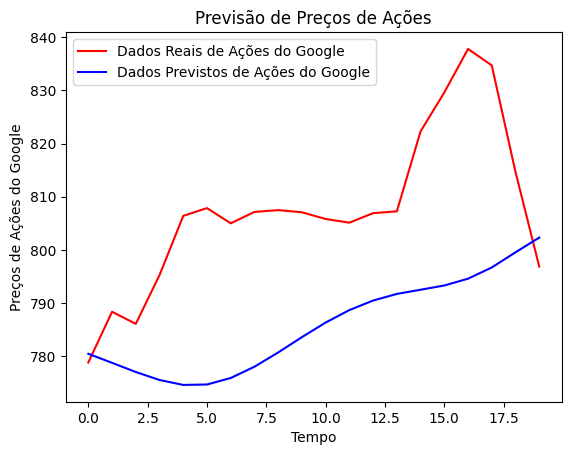

In [32]:
plt.plot(abertura_real, color='red', label='Dados Reais de Ações do Google')
plt.plot(variavel_final, color='blue', label='Dados Previstos de Ações do Google')
plt.title('Previsão de Preços de Ações')
plt.xlabel('Tempo')
plt.ylabel('Preços de Ações do Google')
plt.legend()
plt.show()